<a href="https://colab.research.google.com/github/zxl3651/opensourceproject/blob/master/kinship_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##데이터셋 다운로드

In [3]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb1hztk047VFk2j9bI7JKmEBtkWpABZ8vfX5_m0cdSjQHw?download=1 -O custom_korean_family_dataset_resolution_256.zip
!unzip custom_korean_family_dataset_resolution_256.zip -d ./custom_korean_family_dataset_resolution_256

In [4]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.5 MB/s eta 0:00:00


In [5]:
import random
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

import torch
import torch.nn as nn

#나이예측 인공지능 라이브러리 Load
import torch.optim as optim
import torchvision
from torchvision import transforms, models

#from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from facenet_pytorch import InceptionResnetV1

In [6]:
#kinship_verification parsing function
def kin_parsing(metadata):
    family_set = set()
    family_to_person_map = dict()
    person_to_image_map = dict()
    # iterate all rows in the metadata file
    for idx, row in metadata.iterrows():
        family_id = row["family_id"]
        person_id = row["person_id"]
        key = family_id + "_" + person_id
        image_path = row["image_path"]
        if family_id not in family_set:
            family_set.add(family_id)
            family_to_person_map[family_id] = []
        if person_id not in family_to_person_map[family_id]:
            family_to_person_map[family_id].append(str(person_id))    
            person_to_image_map[key] = []
        person_to_image_map[key].append(image_path) # save all image paths
    family_list = list(family_set)
    return family_list, family_to_person_map, person_to_image_map

batch_size = 64
lr = 0.001
log_step = 20
weights = [6, 5, 2]
weight_map = {
    'D': 0,
    'D2': 0,
    'D3': 0,
    'D4': 0,
    'S': 0,
    'S2': 0,
    'S3': 0,
    'S4': 0,
    'F': 1,
    'M': 1,
    'GF': 2,
    'GM': 2
}

## 데이터셋 종류
* Training dataset
  * have 10,025 images.
* Validation dataset
  * have 1,539 images.
* Test dataset
  * have 1,504 images.

In [7]:
class TrainDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        family_list, family_to_person_map, person_to_image_map = kin_parsing(meta_data)
        self.family_list = family_list
        self.family_to_person_map = family_to_person_map
        self.person_to_image_map = person_to_image_map

    def __len__(self):
        return len(self.meta_data) * 2
               
    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            # choice a single family
            family_id = random.choice(self.family_list)
            # choice 2 different person in a single family
            p1, p2 = random.sample(self.family_to_person_map[family_id], 2) 
            key1 = family_id + "_" + p1
            key2 = family_id + "_" + p2
            label = 1
        # negative samples (not family)
        else:
            # choice 2 different familiy
            f1, f2 = random.sample(self.family_list, 2)
            # choice a person in each family
            p1 = random.choice(self.family_to_person_map[f1])
            p2 = random.choice(self.family_to_person_map[f2])
            key1 = f1 + "_" + p1
            key2 = f2 + "_" + p2
            label = 0

        path1 = random.choice(self.person_to_image_map[key1])
        path2 = random.choice(self.person_to_image_map[key2])

        img1 = Image.open(os.path.join(self.image_directory, path1))
        img2 = Image.open(os.path.join(self.image_directory, path2))

        g1 = path1.split('_')[2]
        g2 = path2.split('_')[2]
        weight = weights[abs(weight_map[g1] - weight_map[g2])]
        
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)
        
        return img1, img2, label, weight


In [8]:
class EvaluationDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.positive_folder = os.path.join(image_directory, "positive")
        self.negative_folder = os.path.join(image_directory, "negative")
        self.positive_list = os.listdir(self.positive_folder)
        self.negative_list = os.listdir(self.negative_folder)
        self.transform = transform

    def __len__(self):
        return len(self.positive_list) + len(self.negative_list)

    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            result_folder = os.path.join(self.positive_folder, self.positive_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 1
        # negative samples (not family)
        else:
            result_folder = os.path.join(self.negative_folder, self.negative_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 0

        img1 = Image.open(os.path.join(result_folder, file1))
        img2 = Image.open(os.path.join(result_folder, file2))

        g1 = file1.split('_')[2]
        g2 = file2.split('_')[2]
        weight = weights[abs(weight_map[g1] - weight_map[g2])]

        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)

        return img1, img2, label, weight

In [9]:
kin_train_meta_data_path = "./custom_korean_family_dataset_resolution_256/custom_train_dataset.csv"
kin_train_meta_data = pd.read_csv(kin_train_meta_data_path)
kin_train_image_directory = "./custom_korean_family_dataset_resolution_256/train_images"

kin_val_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_val_dataset"
kin_test_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_test_dataset"

kin_train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

kin_val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

kin_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

kin_train_dataset = TrainDataset(kin_train_meta_data, kin_train_image_directory, kin_train_transform)
kin_train_dataloader = DataLoader(kin_train_dataset, batch_size=batch_size, shuffle=True)

kin_val_dataset = EvaluationDataset(kin_val_image_directory, kin_val_transform)
kin_val_dataloader = DataLoader(kin_val_dataset, batch_size=batch_size, shuffle=False)

kin_test_dataset = EvaluationDataset(kin_test_image_directory, kin_test_transform)
kin_test_dataloader = DataLoader(kin_test_dataset, batch_size=batch_size, shuffle=False)


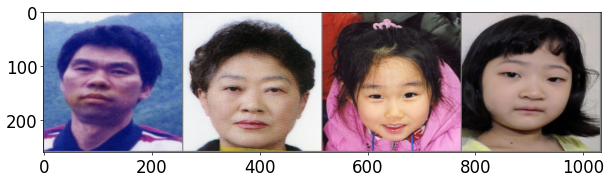

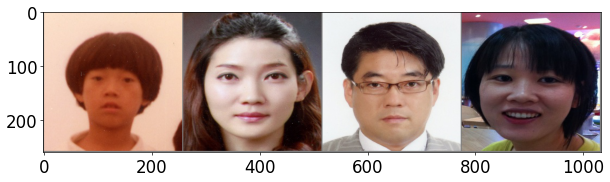

tensor([0, 1, 0, 1])


In [23]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def kin_imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()


# load a batch of train image
kin_iterator = iter(kin_train_dataloader)

# visualize a batch of train image
img1, img2, label, weight = next(kin_iterator)
kin_out = torchvision.utils.make_grid(img1[:4])
kin_imshow(kin_out)
kin_out = torchvision.utils.make_grid(img2[:4])
kin_imshow(kin_out)
print(label[:4]) # 1: family, 0: not family


## 모델 정의

In [11]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = InceptionResnetV1(pretrained='vggface2')
        self.emb_dim = 512

        self.last = nn.Sequential(
            nn.Linear(4 * self.emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, input1, input2):
        emb1 = self.encoder(input1)
        emb2 = self.encoder(input2)
        
        x1 = torch.pow(emb1, 2) - torch.pow(emb2, 2)
        x2 = torch.pow(emb1 - emb2, 2)
        x3 = emb1 * emb2
        x4 = emb1 + emb2
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last(x)

        return x

## 모델 학습

In [24]:
net = SiameseNet().cuda() #기존 GPU를 colab에서 사용하지 않았기 때문에 런타임 유형 변경에서 하드웨어 가속기를 GPU로 설정해준다.
net = torch.nn.DataParallel(net)

criterion = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.Adam(net.parameters(), lr=lr) # 테스트를 위해 바꿈(원래 SGD)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
sigmoid = nn.Sigmoid()

In [25]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    net.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(kin_train_dataloader):
        optimizer.zero_grad()
        
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        output = net(img1, img2)
        preds = sigmoid(output) >= 0.5
        loss = criterion(output, label)
        loss = loss * weight
        loss = torch.mean(loss)

        loss.backward()
        optimizer.step()
        
        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [26]:
def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(kin_val_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5
            loss = criterion(output, label)
            loss = loss * weight
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

## 구글드라이브 연동

In [20]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
saved_path = "/content/gdrive/MyDrive"
num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))
    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(net.state_dict(), f'{saved_path}/best_checkpoint_epoch_{epoch + 1}.pth')
    torch.save(net.state_dict(), f'{saved_path}/checkpoint_epoch_{epoch + 1}.pth')

torch.save(net.state_dict(), f'{saved_path}/last_checkpoint_epoch_{num_epochs}.pth')

net.load_state_dict(torch.load(f'{saved_path}/best_checkpoint_epoch_' + str(best_epoch + 1) + '.pth'))

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.05946107059717178, running train accuracy: 0.48828125
[Batch: 40] running train loss: 0.05691948924213648, running train accuracy: 0.48554688692092896
[Batch: 60] running train loss: 0.05592280067503452, running train accuracy: 0.491666704416275
[Batch: 80] running train loss: 0.0551985748577863, running train accuracy: 0.49433594942092896
[Batch: 100] running train loss: 0.0547788280621171, running train accuracy: 0.49546873569488525
[Batch: 120] running train loss: 0.054449002041170994, running train accuracy: 0.4934896230697632
[Batch: 140] running train loss: 0.05418792055653674, running train accuracy: 0.49609375
[Batch: 160] running train loss: 0.05414200450759381, running train accuracy: 0.4964843690395355
[Batch: 180] running train loss: 0.05406410137398376, running train accuracy: 0.4940972328186035
[Batch: 200] running train loss: 0.05392837591469288, running train accuracy: 0.4953906238079071
[Batch: 220] running train 

KeyboardInterrupt: ignored

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


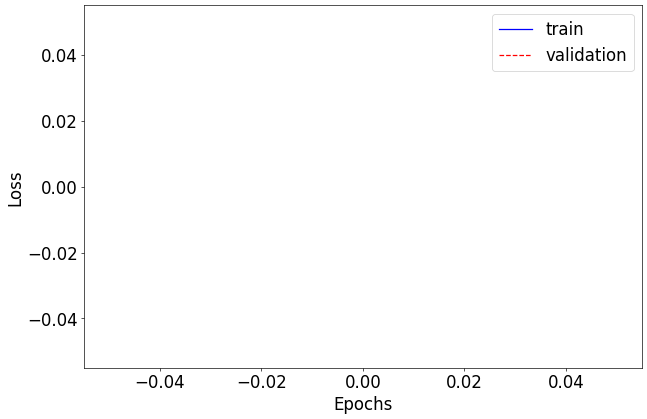

In [ ]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

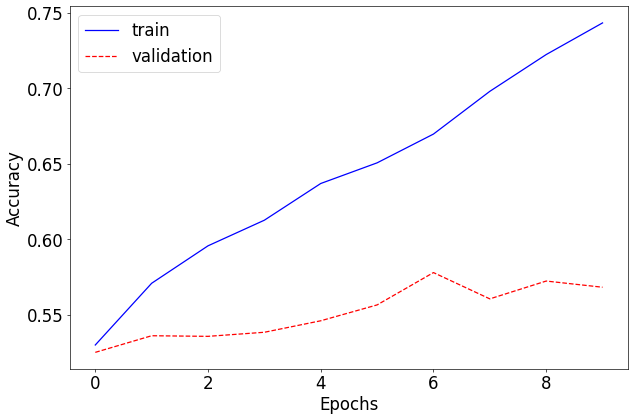

In [ ]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [ ]:
def test():
    start_time = time.time()
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(kin_test_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5
            loss = criterion(output, label)
            loss = loss * weight
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

test()

[Batch: 1] running test loss: 0.05900711566209793, running test accuracy: 0.46875
[Batch: 20] running test loss: 0.058423999883234504, running test accuracy: 0.49687501788139343
[Batch: 40] running test loss: 0.0583155513741076, running test accuracy: 0.4925781190395355
[Batch: 60] running test loss: 0.05821981014062961, running test accuracy: 0.4958333671092987
[Batch: 80] running test loss: 0.058233622228726745, running test accuracy: 0.49824219942092896
[Batch: 100] running test loss: 0.05826993059366942, running test accuracy: 0.4990624785423279
[Batch: 120] running test loss: 0.05826038435722391, running test accuracy: 0.49726563692092896
[Batch: 140] running test loss: 0.05823466022099767, running test accuracy: 0.49687498807907104
test loss: 0.05855406310558319, accuracy: 0.49859997630119324
elapsed time: 117.16796517372131


(0.05855406310558319, 0.49859997630119324)

In [ ]:
checkpoints = [6, 7, 8, 9, 10]

models = []
for checkpoint in checkpoints:
    model = SiameseNet().cuda()
    model = nn.DataParallel(model)
    state_dict = torch.load(f"{saved_path}/checkpoint_epoch_{checkpoint}.pth")
    model.load_state_dict(state_dict)
    
    models.append(model)

In [ ]:
def test_ensembles():
    start_time = time.time()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        preds = 0
        losses = 0
        for model in models:
            model.eval()
            with torch.no_grad():
                output = model(img1, img2)
                preds += sigmoid(output) / len(models)
                loss = criterion(output, label)
                loss = loss * weight
                loss = torch.mean(loss)
                losses += loss / len(models)

        pred = preds >= 0.5
        total += label.shape[0]
        running_loss += losses.item()
        running_corrects += torch.sum(pred == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

test_ensembles()

[Batch: 1] running test loss: 0.0639495924115181, running test accuracy: 0.65625
[Batch: 20] running test loss: 0.05976540111005306, running test accuracy: 0.5914062857627869
[Batch: 40] running test loss: 0.05825203619897366, running test accuracy: 0.6117187738418579
[Batch: 60] running test loss: 0.058280292836328344, running test accuracy: 0.6062500476837158
[Batch: 80] running test loss: 0.05817536762915552, running test accuracy: 0.6078125238418579
[Batch: 100] running test loss: 0.058348547220230106, running test accuracy: 0.6104687452316284
[Batch: 120] running test loss: 0.058598570867131154, running test accuracy: 0.6078125238418579
[Batch: 140] running test loss: 0.0585672230858888, running test accuracy: 0.6084821224212646
test loss: 0.058920782709121704, accuracy: 0.607699990272522
elapsed time: 387.14785528182983


(0.058920782709121704, 0.607699990272522)

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERO90Zk8tGlGn4nM1VM6UpkBuJV5rdKmYU4ia7wRp-K4CA?download=1 -O saved_best_checkpoint_epoch.pth

In [ ]:
net = SiameseNet().cuda()
net = nn.DataParallel(net)
state_dict = torch.load(f"./saved_best_checkpoint_epoch.pth")
net.load_state_dict(state_dict)

<All keys matched successfully>

#**정확도 : 60.35%**

In [ ]:
test()

[Batch: 1] running test loss: 0.06775327026844025, running test accuracy: 0.5625
[Batch: 20] running test loss: 0.06250344384461641, running test accuracy: 0.5859375
[Batch: 40] running test loss: 0.06175083499401808, running test accuracy: 0.602734386920929
[Batch: 60] running test loss: 0.062014440260827544, running test accuracy: 0.6005208492279053
[Batch: 80] running test loss: 0.06164074665866792, running test accuracy: 0.6048828363418579
[Batch: 100] running test loss: 0.06215522207319737, running test accuracy: 0.6049999594688416
[Batch: 120] running test loss: 0.06233527942871054, running test accuracy: 0.6033854484558105
[Batch: 140] running test loss: 0.0623369002448661, running test accuracy: 0.6025669574737549
test loss: 0.0630569349527359, accuracy: 0.6035000085830688
elapsed time: 119.18155264854431


(0.0630569349527359, 0.6035000085830688)

**# 실제 데이터로 모델 실행**

In [2]:
images = []
image_cnt = 10

for i in range(1, image_cnt + 1):
    filename = f'example_{i}.png'
    image = Image.open(f'{saved_path}/' + filename).convert('RGB') #원래 경로: {saved_path}/korean_face_age_classification_images/ + filename
    image = test_transform(image).unsqueeze(0).cuda()
    images.append(image)

from itertools import combinations


possibles = list(combinations(images, 2))

for possible in possibles:
    one, two = possible

    with torch.no_grad():
        output = net(one, two)
        pred = sigmoid(output) >= 0.5

    result = pred[0][0].item()
    print(f"가족 관계 예측 결과: {result}")
    # print(f"가족 관계 예측 결과: {result} ({sigmoid(output)[0][0].item()})%")
    out = torchvision.utils.make_grid(torch.stack((one[0], two[0])))
    kin_imshow(out.cpu())

NameError: ignored